## Model una vegada comença la partida

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from metric_selection import metriques, grafiques, curva_ROC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold

%matplotlib inline
sns.set_style('whitegrid')

In [3]:
df = pd.read_csv("games_2.csv")
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,...,white_loss_streak,black_win_streak,black_loss_streak,diff_win_streak,diff_loss_streak,opening_group_A,opening_group_B,opening_group_C,opening_group_D,opening_group_E
0,hmdl0w8w,-2.056863,2013-08-17 20:33:53.173,1.376772e+12,19,resign,1,12+8,julito,899,...,-0.421876,-0.353240,-0.423498,0.005286,0.011275,-0.491017,-0.592896,1.260727,-0.393824,-0.160738
1,6trard8c,0.486177,2013-08-17 20:37:48.314,1.376772e+12,43,mate,1,7+15,kiii,1500,...,0.168437,-0.353240,-0.423498,0.005286,0.393599,-0.491017,1.686636,-0.793193,-0.393824,-0.160738
2,2hf0bf3b,0.486177,2013-08-19 16:38:07.783,1.376931e+12,27,resign,1,10+20,goldenfork,1381,...,-0.421876,0.107369,-0.423498,-0.314569,0.011275,-0.491017,-0.592896,1.260727,-0.393824,-0.160738
3,63x6m6fx,-2.056863,2013-08-19 17:23:45.599,1.376934e+12,84,resign,0,10+8,kiii,1170,...,0.168437,-0.353240,-0.423498,0.005286,0.393599,-0.491017,-0.592896,1.260727,-0.393824,-0.160738
4,rk7l19ti,0.486177,2013-08-19 20:56:29.445,1.376947e+12,51,mate,1,20+15,kiii,1348,...,0.758749,-0.353240,-0.423498,0.005286,0.775923,-0.491017,1.686636,-0.793193,-0.393824,-0.160738


### Preprocessing (moviments)

In [4]:
df['moves'] # Mirem la notació en que tenim els moviments de la partida

0        e4 e5 Qh5 Nf6 Qxe5+ Be7 b3 d6 Qb5+ c6 Qb4 c5 Q...
1        e4 g6 d4 Bg7 Nf3 b6 Nc3 Bb7 Bc4 e6 Bg5 Ne7 O-O...
2        e4 e5 Nf3 Nc6 Bb5 a6 Ba4 b5 Bb3 Bc5 Nxe5 Nxe5 ...
3        e4 e5 Nf3 f6 Bc4 Bc5 d4 d5 Bb5+ c6 Ba4 Bb4+ Nb...
4        e4 Nf6 Nc3 Nc6 Bc4 d6 d3 g6 h3 b6 Nf3 Ne5 Nxe5...
                               ...                        
18815    d4 c6 Nf3 d5 c4 Nf6 Bg5 e6 e3 Be7 Nc3 O-O Bd3 ...
18816    e4 d6 d4 g6 c4 Bg7 Nc3 Nd7 Nf3 b6 Bf4 Bb7 Bd3 ...
18817    e4 e5 Nf3 f5 d3 Nf6 exf5 Nc6 Bg5 d5 Nc3 Be7 Be...
18818    e4 e6 d4 d5 Nd2 Ne7 c3 dxe4 Nxe4 Nf5 Nf3 Bd6 B...
18819    d4 e6 e4 d5 e5 c5 c3 Qb6 Nf3 Nc6 Bd3 cxd4 cxd4...
Name: moves, Length: 18820, dtype: object

DEFINO FUNCIONES PARA HACER FEATURE ENGINEERING CON LOS MOVIMIENTOS

In [5]:
import chess

# Funcion que me devuelve el estado del tablero a partir de los movimientos
def board_after_n_moves(moves_str, n_moves=None):
    board = chess.Board()
    moves = moves_str.split()
    
    if n_moves is not None:
        moves = moves[:n_moves]

    for mv in moves:
        try:
            board.push_san(mv)  # SAN = notación estándar que tú tienes
        except:
            break  # por si algún movimiento está mal anotado

    return board


piece_values = {
    chess.PAWN:   1,
    chess.KNIGHT: 3,
    chess.BISHOP: 3,
    chess.ROOK:   5,
    chess.QUEEN:  9,
    chess.KING:   0
}

# Funcion que me devuelve las nuevas variables creadas. (nº de piezas, valor de las piezas)
def material_features(board):
    white_total = 0
    black_total = 0
    white_count = 0
    black_count = 0
    
    for piece in board.piece_map().values():
        value = piece_values[piece.piece_type]
        
        if piece.color == chess.WHITE:
            white_total += value
            white_count += 1
        else:
            black_total += value
            black_count += 1
    
    return {
        "white_piece_count": white_count,
        "black_piece_count": black_count,
        "white_material_value": white_total,
        "black_material_value": black_total,
        "material_balance": white_total - black_total
    }

CENTER_SQUARES = [
    chess.D4, chess.E4, chess.D5, chess.E5
]

# Funcion que devuelve los valores para evaluar el control del centro del tablero
def center_control(board):    
    white = 0
    black = 0
    
    for sq in CENTER_SQUARES: 
        attackers_white = board.attackers(chess.WHITE, sq) # Devuelve los atacantes de una casilla específica por color
        attackers_black = board.attackers(chess.BLACK, sq)
        
        if attackers_white:
            white += 1
        if attackers_black:
            black += 1
            
    return {
        "white_center_control": white,
        "black_center_control": black
    }

PST = {
    chess.PAWN: np.array([
        0, 0, 0, 0, 0, 0, 0, 0,
        5, 10, 10,-20,-20, 10, 10, 5,
        5, -5,-10, 0, 0,-10, -5, 5,
        0, 0, 0, 20, 20, 0, 0, 0,
        5, 5,10,25,25,10,5,5,
        10,10,20,30,30,20,10,10,
        50,50,50,50,50,50,50,50,
        0,0,0,0,0,0,0,0
    ]),
    chess.KNIGHT: np.array([
        -50,-40,-30,-30,-30,-30,-40,-50,
        -40,-20, 0, 0, 0, 0,-20,-40,
        -30, 0,10,15,15,10,0,-30,
        -30, 5,15,20,20,15,5,-30,
        -30, 0,15,20,20,15,0,-30,
        -30, 5,10,15,15,10,5,-30,
        -40,-20, 0,5,5,0,-20,-40,
        -50,-40,-30,-30,-30,-30,-40,-50
    ]),
    chess.BISHOP: np.zeros(64),
    chess.ROOK: np.zeros(64),
    chess.QUEEN: np.zeros(64),
    chess.KING: np.zeros(64),
}


# Más robusto: generar tablero con turn=color y contar legal_moves
def mobility_for_color(board, color):
    b2 = board.copy()
    b2.turn = color
    return b2.legal_moves.count()


# PST score (suma simples)
def pst_score(board, color):
    total = 0
    for sq, p in board.piece_map().items():
        val = PST.get(p.piece_type)
        if val is None:
            continue
        index = sq
        if p.color == chess.BLACK:
            # invertir para perspectiva black
            index = chess.square_mirror(index)
        total += val[index] * (1 if p.color==color else -1)
    return total if color==chess.WHITE else -total


# función agregadora: nuevas features posicionales
def positional_features(board):
    feats = {}
    feats.update({
        "white_mobility": mobility_for_color(board, chess.WHITE),
        "black_mobility": mobility_for_color(board, chess.BLACK),
        "white_PST": pst_score(board, chess.WHITE),
        "black_PST": pst_score(board, chess.BLACK),
    })
    # espacio relativo: casillas controladas en la mitad rival
    white_half = [sq for sq in chess.SQUARES if chess.square_rank(sq) >= 4]  # ranks 5-8 => 4..7
    black_half = [sq for sq in chess.SQUARES if chess.square_rank(sq) <= 3]  # ranks 1-4 => 0..3
    feats["white_space"] = sum(1 for sq in white_half if board.attackers(chess.WHITE, sq))
    feats["black_space"] = sum(1 for sq in black_half if board.attackers(chess.BLACK, sq))
    return feats


In [6]:
def extract_features_from_moves(moves_str, n_moves=None):
    board = board_after_n_moves(moves_str, n_moves)
    
    feats = {}
    feats.update(material_features(board))
    feats.update(center_control(board))
    feats.update(positional_features(board))
    
    return feats

In [7]:
# pruebo las funciones
moves = "e4 e5 Qh5 Nf6 Qxe5+ Be7"

features = extract_features_from_moves(moves, n_moves=6)
print(features)

{'white_piece_count': 16, 'black_piece_count': 15, 'white_material_value': 39, 'black_material_value': 38, 'material_balance': 1, 'white_center_control': 3, 'black_center_control': 2, 'white_mobility': 42, 'black_mobility': 23, 'white_PST': np.float64(-30.0), 'black_PST': np.float64(-30.0), 'white_space': 13, 'black_space': 4}


In [8]:
def add_move_features(df,n_moves=None):
    feature_rows = []

    # Si n_moves es un escalar, conviértelo en una serie constante
    if not hasattr(n_moves, "__iter__"):
        n_moves = pd.Series([n_moves] * len(df), index=df.index)

    for moves, n in zip(df["moves"], n_moves):
        if pd.isna(n):
            feature_rows.append(extract_features_from_moves(moves, None))
        else:
            feature_rows.append(extract_features_from_moves(moves, int(n)))

    feature_df = pd.DataFrame(feature_rows)
    return pd.concat([df, feature_df], axis=1)

In [9]:
# 1) Contar plies
def count_plies(moves_str):
    if pd.isna(moves_str):
        return 0
    return len(moves_str.split())

In [10]:
df["num_plies"] = df["moves"].apply(count_plies)

# Filtrar si lo deseas (opcional)
df_filtered = df[df["num_plies"] >= 60].copy()
df_filtered.reset_index(drop=True, inplace=True)

# Añadir features con N distinto por partida
df_filtered = add_move_features(df_filtered, n_moves=60)

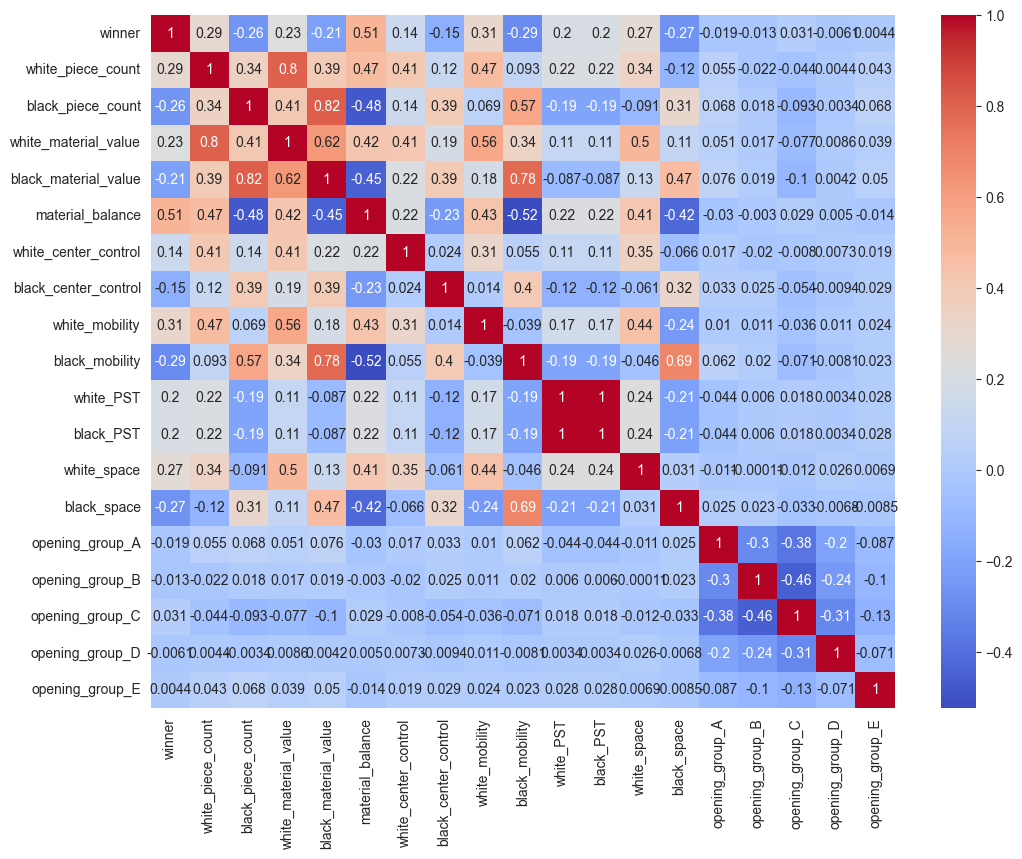

In [11]:
variables_previes = [
    # Variables previas al juego / historial
    'winner',
    'white_piece_count', 'black_piece_count',

    'white_material_value', 'black_material_value', 'material_balance',
    

    # Control del centro
    'white_center_control',
    'black_center_control',
    
    # Movilidad
    'white_mobility',
    'black_mobility',
    
    # PST / Piece-Square Table
    'white_PST',
    'black_PST',
    
    # Espacio / control relativo
    'white_space',
    'black_space',

    'opening_group_A', 'opening_group_B', 'opening_group_C', 'opening_group_D', 'opening_group_E'
]
corr_matrix = df_filtered[variables_previes].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

QUITAMOS LOS OPENING GROUPS

In [12]:
df["num_plies"] = df["moves"].apply(count_plies)

# Filtrar si lo deseas (opcional)
df_filtered = df[df["num_plies"] >= df['opening_ply']].copy()
df_filtered.reset_index(drop=True, inplace=True)

# Añadir features con N distinto por partida
df_filtered = add_move_features(df_filtered, n_moves=df['opening_ply'])

---

MODEL SELECTION I CROSS VALIDATION

Gradient Boosting
              precision    recall  f1-score   support

           0       0.65      0.64      0.64      1742
           1       0.69      0.70      0.69      2022

    accuracy                           0.67      3764
   macro avg       0.67      0.67      0.67      3764
weighted avg       0.67      0.67      0.67      3764

Accuracy: 0.6700318809776833


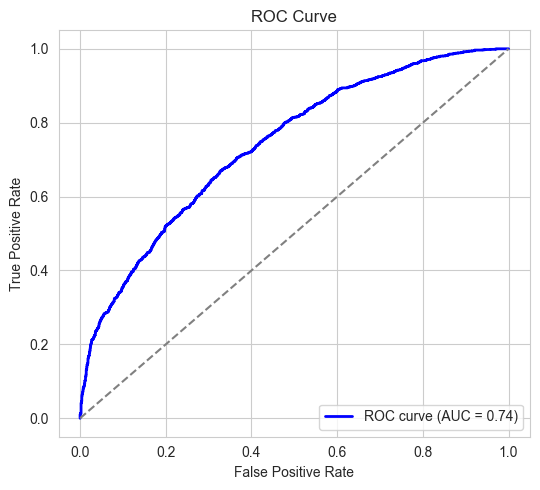

In [ ]:
# N = opening_ply

explanatory_variables = [
                        #Variables prèvies
                        'diff_rating', 
                        'diff_global_winrate',
                        'vs_white_winrate', 'vs_prev_matches',
                        'diff_experience',
                        'diff_win_streak',
                        'diff_loss_streak',

                        'white_piece_count', 'black_piece_count',

                        # Variables de material
                        'white_material_value', 'black_material_value', 'material_balance',
                        
                        # Control del centro
                        'white_center_control',
                        'black_center_control',
                        
                        # Mobilitat
                        'white_mobility',
                        'black_mobility',
                        
                        # PST / Piece-Square Table
                        'white_PST',
                        'black_PST',
                        
                        # Espacio / control relativo
                        'white_space',
                        'black_space'
                        ]
target_variable = "winner"

X = df_filtered[explanatory_variables]
y = df_filtered[target_variable]  # 1 = white, 0 = black

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

print("Gradient Boosting")
metriques(gb_model,X_test,y_test)
curva_ROC(gb_model,X_test,y_test)

SVM
              precision    recall  f1-score   support

           0       0.65      0.51      0.57      1742
           1       0.64      0.76      0.70      2022

    accuracy                           0.64      3764
   macro avg       0.64      0.63      0.63      3764
weighted avg       0.64      0.64      0.64      3764

Accuracy: 0.6442614240170031


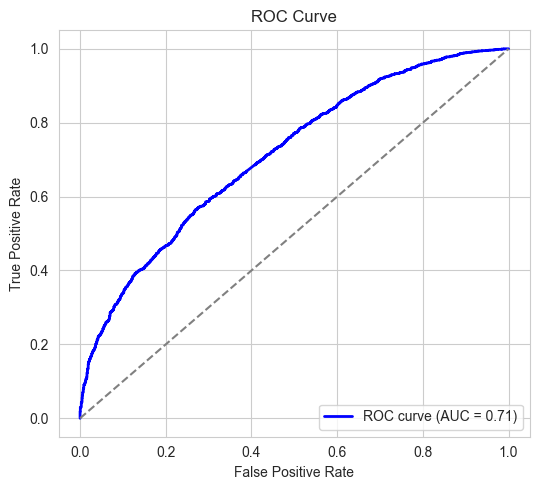

In [14]:
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)

print("SVM")
metriques(svm_model,X_test,y_test)
curva_ROC(svm_model,X_test,y_test)

Random Forest
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      1742
           1       0.68      0.68      0.68      2022

    accuracy                           0.66      3764
   macro avg       0.66      0.66      0.66      3764
weighted avg       0.66      0.66      0.66      3764

Accuracy: 0.6575451647183846


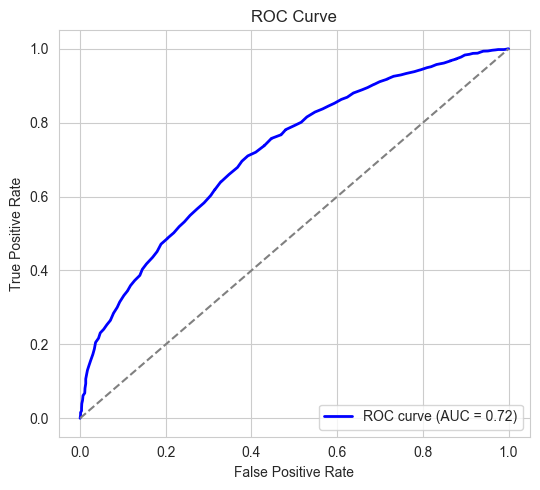

In [15]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

print("Random Forest")
metriques(rf_model,X_test,y_test)
curva_ROC(rf_model,X_test,y_test)

QUITAMOS SVM PORQUE EMPEORA AL MODELO PREVIO


N_PLIES = 4
              precision    recall  f1-score   support

           0       0.64      0.63      0.63      1742
           1       0.69      0.70      0.69      2022

    accuracy                           0.67      3764
   macro avg       0.66      0.66      0.66      3764
weighted avg       0.67      0.67      0.67      3764

Accuracy: 0.6655154091392136


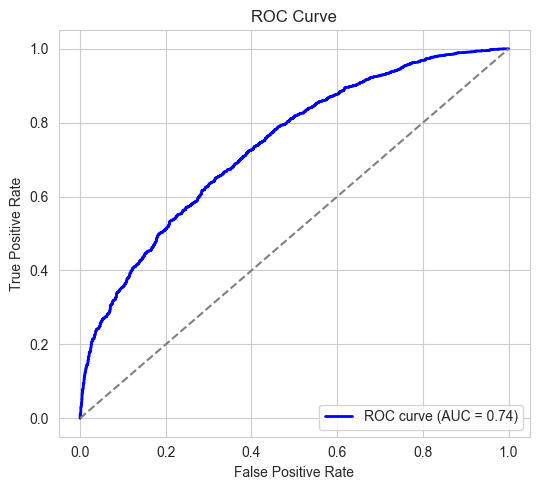


N_PLIES = 8
              precision    recall  f1-score   support

           0       0.67      0.64      0.66      1758
           1       0.69      0.72      0.71      1970

    accuracy                           0.68      3728
   macro avg       0.68      0.68      0.68      3728
weighted avg       0.68      0.68      0.68      3728

Accuracy: 0.6842811158798283


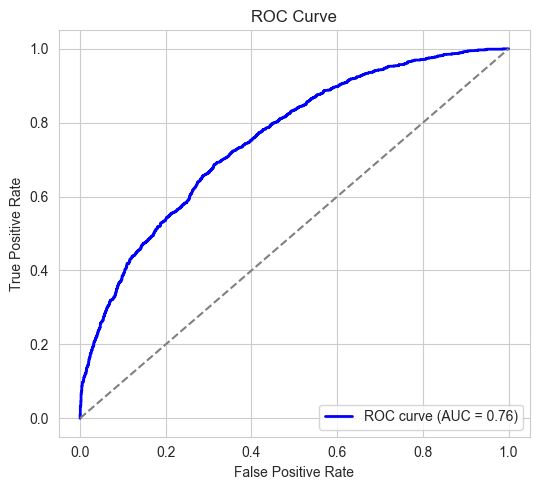


N_PLIES = 16
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      1720
           1       0.69      0.70      0.69      1880

    accuracy                           0.68      3600
   macro avg       0.68      0.68      0.68      3600
weighted avg       0.68      0.68      0.68      3600

Accuracy: 0.6769444444444445


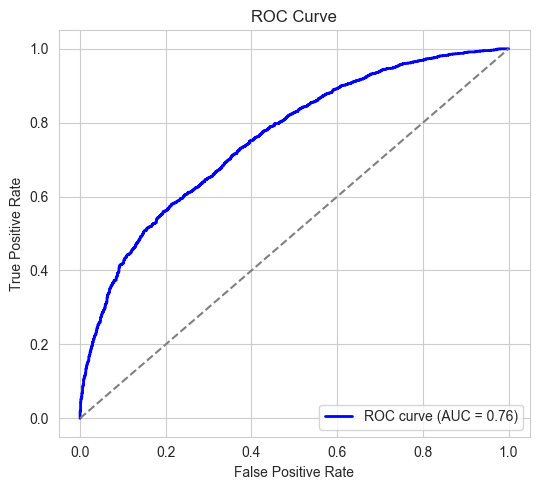


N_PLIES = 20
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1646
           1       0.70      0.69      0.70      1857

    accuracy                           0.68      3503
   macro avg       0.68      0.68      0.68      3503
weighted avg       0.68      0.68      0.68      3503

Accuracy: 0.6779902940336854


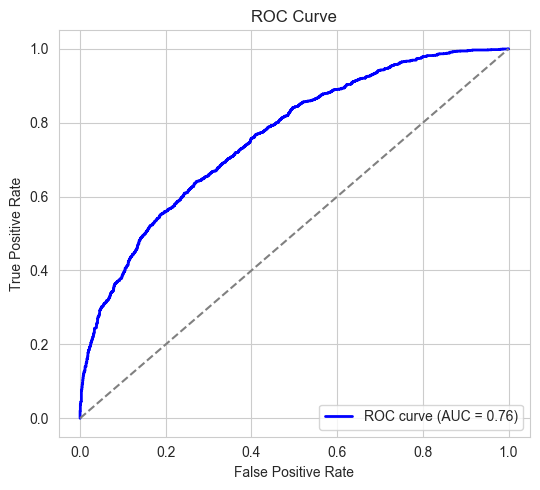


N_PLIES = 30
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      1564
           1       0.71      0.70      0.71      1613

    accuracy                           0.71      3177
   macro avg       0.71      0.71      0.71      3177
weighted avg       0.71      0.71      0.71      3177

Accuracy: 0.7050676739062008


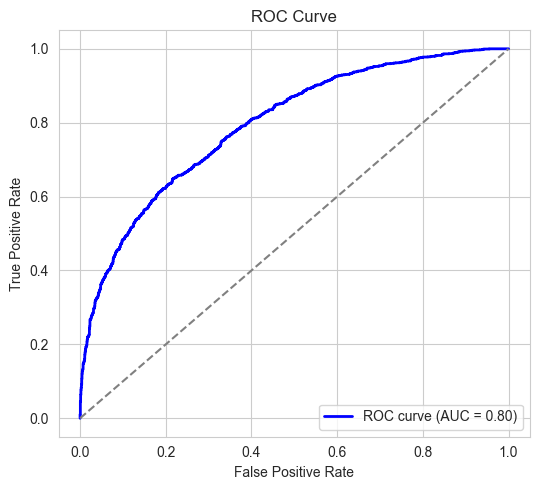


N_PLIES = 40
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1322
           1       0.75      0.74      0.74      1399

    accuracy                           0.74      2721
   macro avg       0.74      0.74      0.74      2721
weighted avg       0.74      0.74      0.74      2721

Accuracy: 0.7405365674384418


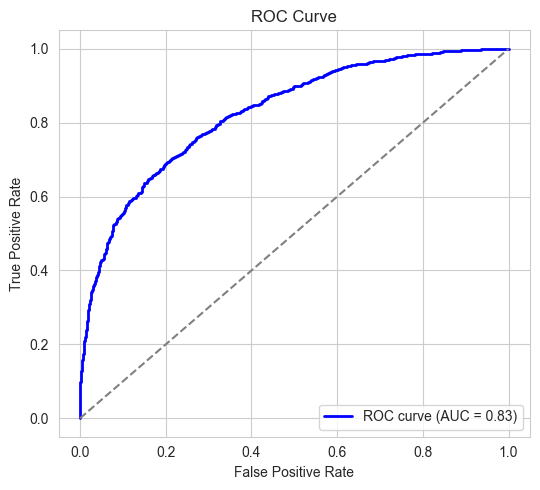


N_PLIES = 60
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       811
           1       0.81      0.78      0.80       836

    accuracy                           0.80      1647
   macro avg       0.80      0.80      0.80      1647
weighted avg       0.80      0.80      0.80      1647

Accuracy: 0.7978142076502732


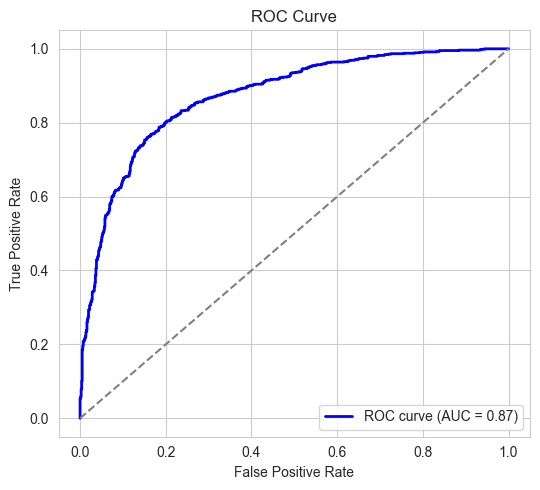


N_PLIES = 80
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       448
           1       0.82      0.85      0.83       423

    accuracy                           0.84       871
   macro avg       0.84      0.84      0.84       871
weighted avg       0.84      0.84      0.84       871

Accuracy: 0.8369690011481056


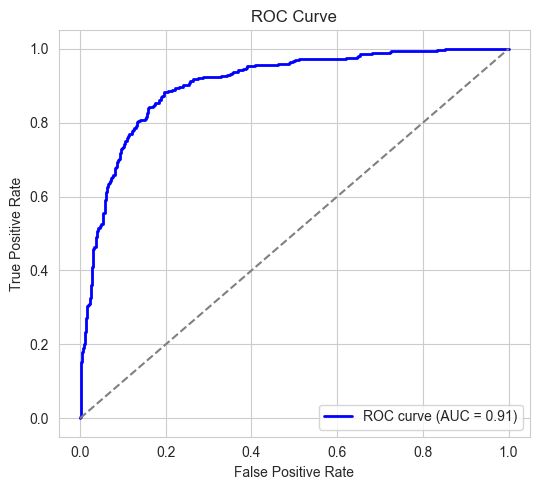


N_PLIES = 100
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       209
           1       0.87      0.82      0.84       234

    accuracy                           0.84       443
   macro avg       0.84      0.84      0.84       443
weighted avg       0.84      0.84      0.84       443

Accuracy: 0.837471783295711


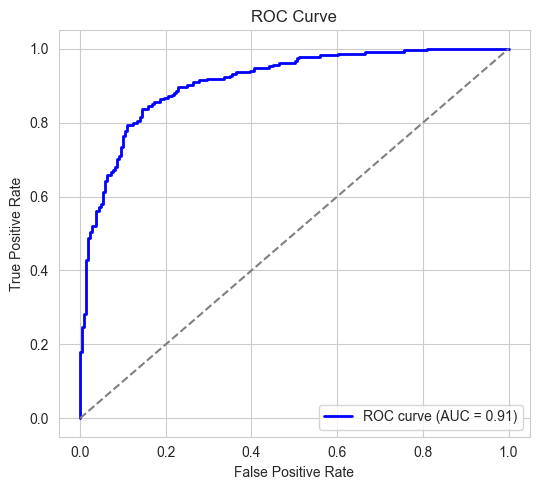


N_PLIES = 120
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        94
           1       0.90      0.90      0.90       100

    accuracy                           0.90       194
   macro avg       0.90      0.90      0.90       194
weighted avg       0.90      0.90      0.90       194

Accuracy: 0.8969072164948454


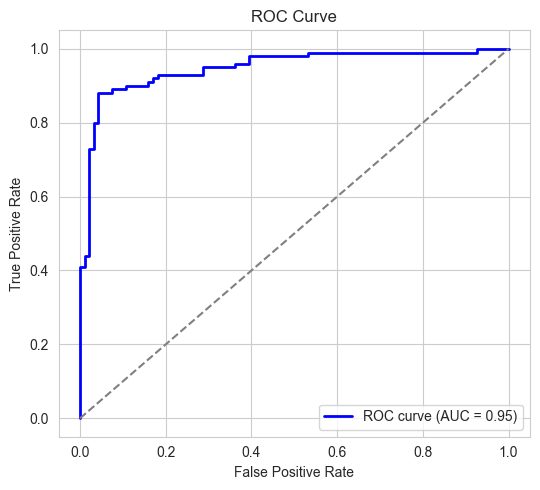


N_PLIES = 150
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        27
           1       0.87      1.00      0.93        20

    accuracy                           0.94        47
   macro avg       0.93      0.94      0.94        47
weighted avg       0.94      0.94      0.94        47

Accuracy: 0.9361702127659575


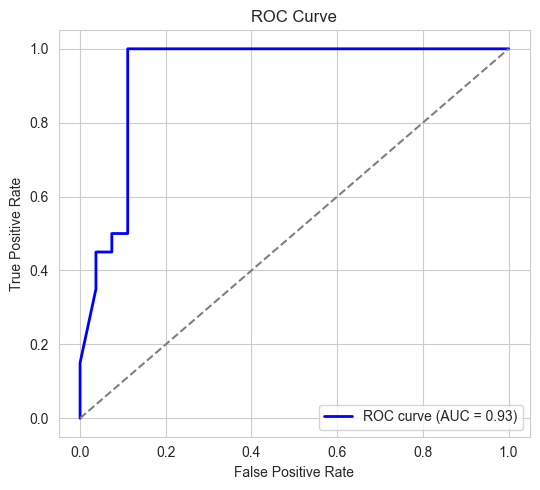


RESULTADOS FINALES:

      N  accuracy  n_partidas
0     4  0.665515       18820
1     8  0.684281       18637
2    16  0.676944       17999
3    20  0.677990       17515
4    30  0.705068       15882
5    40  0.740537       13605
6    60  0.797814        8234
7    80  0.836969        4353
8   100  0.837472        2213
9   120  0.896907         970
10  150  0.936170         231


In [ ]:
# lista de N a evaluar
N_list = [4, 8, 16, 20, 30, 40, 60, 80, 100, 120, 150]

results = []

for N_PLIES in N_list:
    print("\n==============================")
    print(f"N_PLIES = {N_PLIES}")
    print("==============================")
    df["num_plies"] = df["moves"].apply(count_plies)

    df_filtered = df[df["num_plies"] >= N_PLIES].copy()
    df_filtered.reset_index(drop=True, inplace=True)

    df_filtered = add_move_features(df_filtered, n_moves=N_PLIES)

    X = df_filtered[explanatory_variables]
    y = df_filtered[target_variable]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    gb_model = GradientBoostingClassifier()
    gb_model.fit(X_train, y_train)
    y_pred = gb_model.predict(X_test)

    metriques(gb_model, X_test, y_test)
    curva_ROC(gb_model, X_test, y_test)

    # Guardar resultados
    results.append({
        "N": N_PLIES,
        "accuracy": accuracy_score(y_test, y_pred),
        "n_partidas": len(df_filtered)
    })

# Mostrar tabla final
results_df = pd.DataFrame(results)
print("\nRESULTADOS FINALES:\n")
print(results_df)


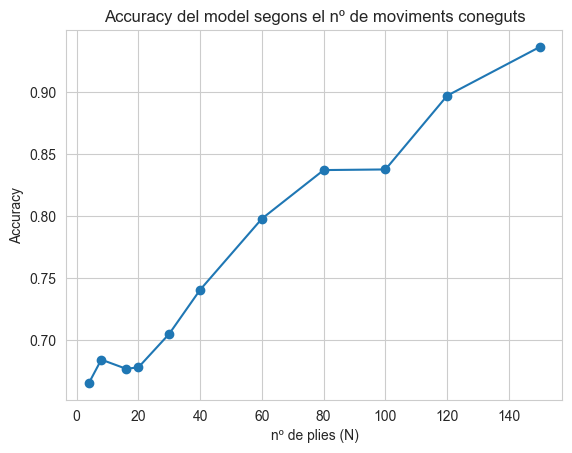

In [17]:
plt.plot(results_df["N"], results_df["accuracy"], marker='o')
plt.xlabel("nº de plies (N)")
plt.ylabel("Accuracy")
plt.title("Accuracy del model segons el nº de moviments coneguts")
plt.show()


N_PLIES = 4
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      1742
           1       0.69      0.65      0.67      2022

    accuracy                           0.66      3764
   macro avg       0.66      0.66      0.66      3764
weighted avg       0.66      0.66      0.66      3764

Accuracy: 0.6567481402763018


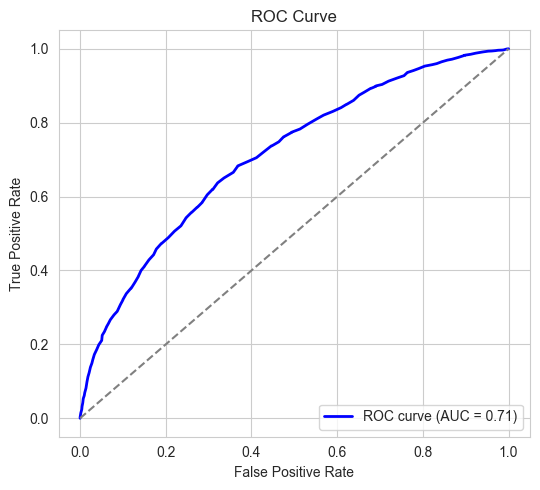


N_PLIES = 8
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      1758
           1       0.69      0.68      0.69      1970

    accuracy                           0.67      3728
   macro avg       0.67      0.67      0.67      3728
weighted avg       0.67      0.67      0.67      3728

Accuracy: 0.6689914163090128


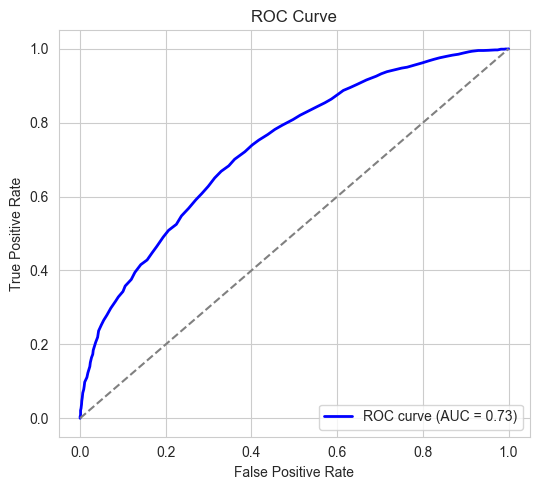


N_PLIES = 16
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1720
           1       0.69      0.69      0.69      1880

    accuracy                           0.68      3600
   macro avg       0.68      0.68      0.68      3600
weighted avg       0.68      0.68      0.68      3600

Accuracy: 0.6761111111111111


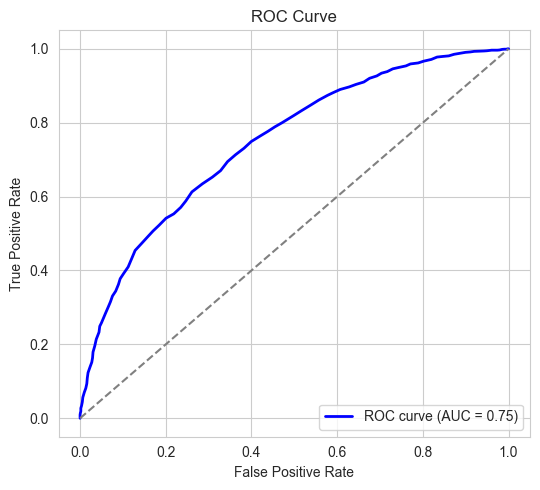


N_PLIES = 20
              precision    recall  f1-score   support

           0       0.65      0.67      0.66      1646
           1       0.70      0.69      0.69      1857

    accuracy                           0.68      3503
   macro avg       0.68      0.68      0.68      3503
weighted avg       0.68      0.68      0.68      3503

Accuracy: 0.678846702826149


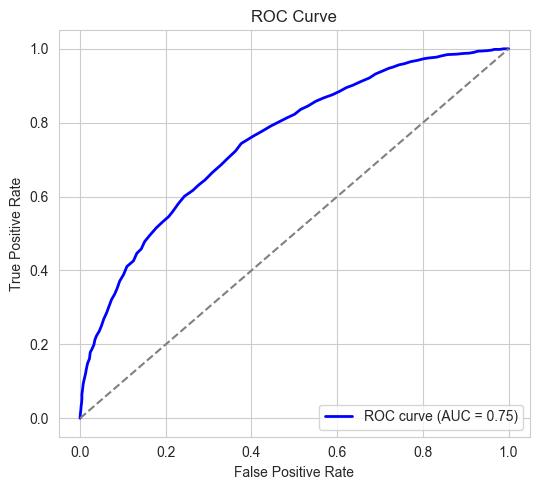


N_PLIES = 30
              precision    recall  f1-score   support

           0       0.70      0.72      0.71      1564
           1       0.72      0.70      0.71      1613

    accuracy                           0.71      3177
   macro avg       0.71      0.71      0.71      3177
weighted avg       0.71      0.71      0.71      3177

Accuracy: 0.7082152974504249


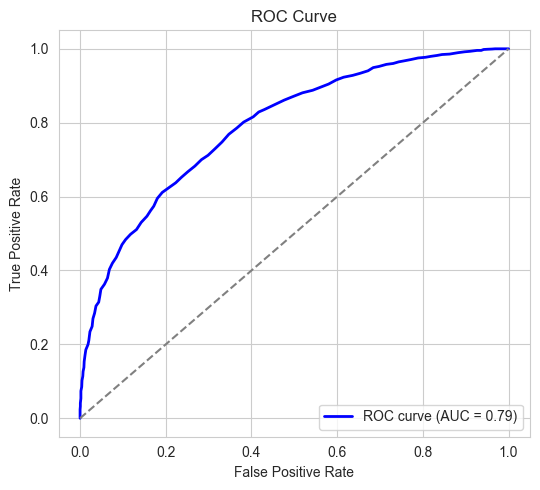


N_PLIES = 40
              precision    recall  f1-score   support

           0       0.74      0.75      0.75      1322
           1       0.76      0.75      0.76      1399

    accuracy                           0.75      2721
   macro avg       0.75      0.75      0.75      2721
weighted avg       0.75      0.75      0.75      2721

Accuracy: 0.75303197353914


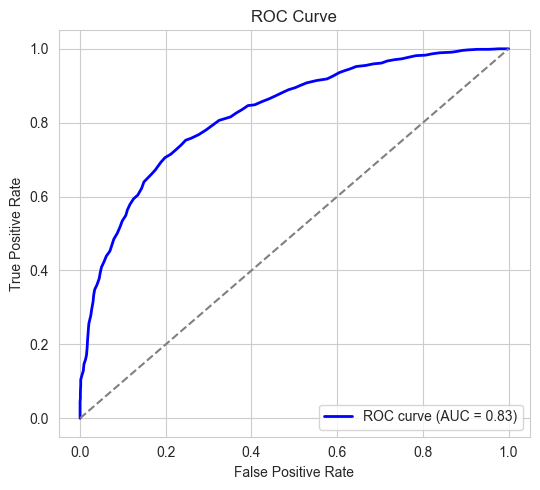


N_PLIES = 60
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       811
           1       0.82      0.77      0.80       836

    accuracy                           0.80      1647
   macro avg       0.80      0.80      0.80      1647
weighted avg       0.80      0.80      0.80      1647

Accuracy: 0.7978142076502732


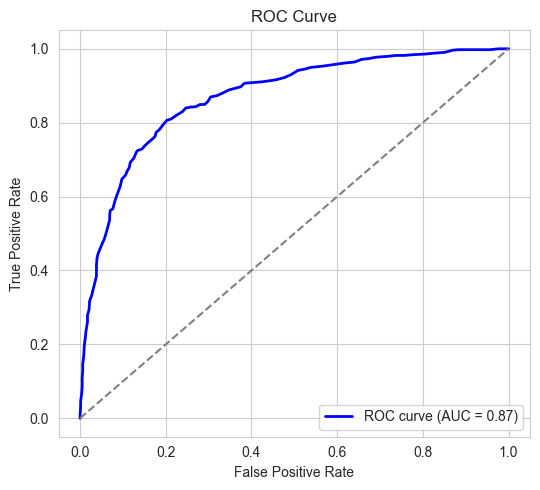


N_PLIES = 80
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       448
           1       0.83      0.84      0.83       423

    accuracy                           0.84       871
   macro avg       0.84      0.84      0.84       871
weighted avg       0.84      0.84      0.84       871

Accuracy: 0.8381171067738232


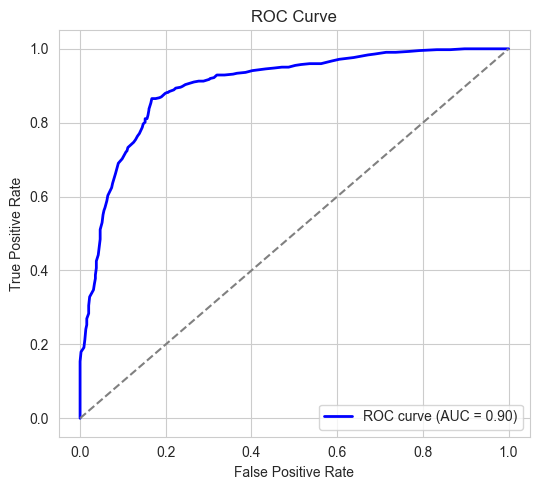


N_PLIES = 100
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       209
           1       0.87      0.82      0.84       234

    accuracy                           0.84       443
   macro avg       0.84      0.84      0.84       443
weighted avg       0.84      0.84      0.84       443

Accuracy: 0.8397291196388262


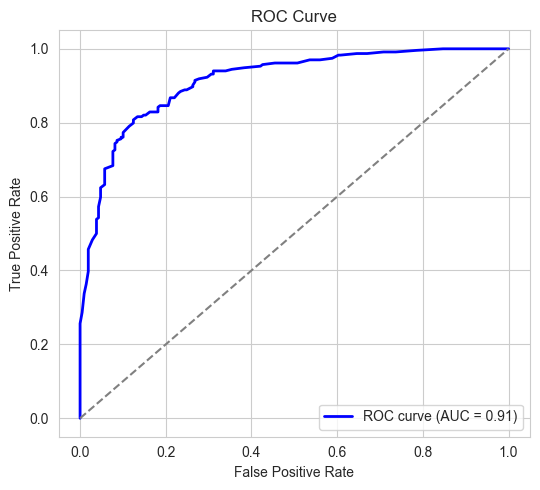


N_PLIES = 120
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        94
           1       0.92      0.91      0.91       100

    accuracy                           0.91       194
   macro avg       0.91      0.91      0.91       194
weighted avg       0.91      0.91      0.91       194

Accuracy: 0.9123711340206185


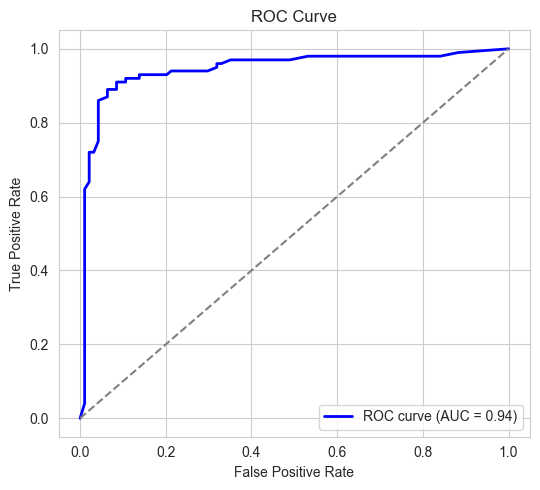


N_PLIES = 150
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        27
           1       0.83      1.00      0.91        20

    accuracy                           0.91        47
   macro avg       0.92      0.93      0.91        47
weighted avg       0.93      0.91      0.92        47

Accuracy: 0.9148936170212766


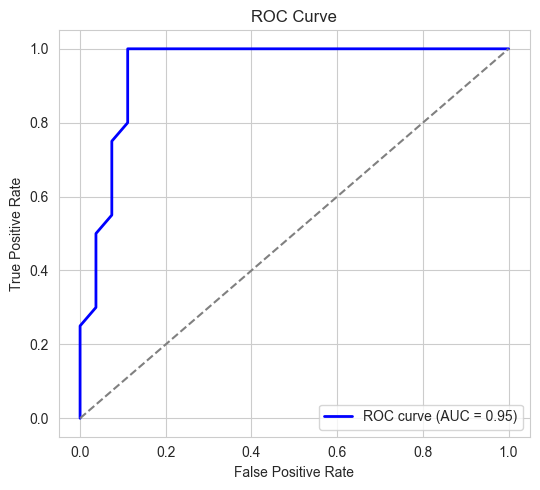


RESULTADOS FINALES:

      N  accuracy  n_partidas
0     4  0.656748       18820
1     8  0.668991       18637
2    16  0.676111       17999
3    20  0.678847       17515
4    30  0.708215       15882
5    40  0.753032       13605
6    60  0.797814        8234
7    80  0.838117        4353
8   100  0.839729        2213
9   120  0.912371         970
10  150  0.914894         231


In [ ]:
results = []

for N_PLIES in N_list:
    print("\n==============================")
    print(f"N_PLIES = {N_PLIES}")
    print("==============================")
    df["num_plies"] = df["moves"].apply(count_plies)

    df_filtered = df[df["num_plies"] >= N_PLIES].copy()
    df_filtered.reset_index(drop=True, inplace=True)

    df_filtered = add_move_features(df_filtered, n_moves=N_PLIES)

    X = df_filtered[explanatory_variables]
    y = df_filtered[target_variable]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    metriques(rf_model, X_test, y_test)
    curva_ROC(rf_model, X_test, y_test)

    # Guardar resultados
    results.append({
        "N": N_PLIES,
        "accuracy": accuracy_score(y_test, y_pred),
        "n_partidas": len(df_filtered)
    })

# Mostrar tabla final
results_df = pd.DataFrame(results)
print("\nRESULTADOS FINALES:\n")
print(results_df)


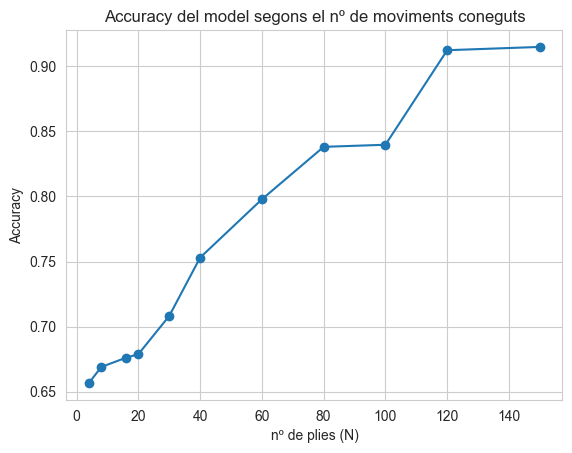

In [19]:
plt.plot(results_df["N"], results_df["accuracy"], marker='o')
plt.xlabel("nº de plies (N)")
plt.ylabel("Accuracy")
plt.title("Accuracy del model segons el nº de moviments coneguts")
plt.show()

FALTA CROSS VALIDATION

FALTA MOSTRAR EL MODELO FINAL ESCOGIDO CON TODAS LAS GRAFICAS Y LA CONFUSION MATRIX